In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
from fitsio import FITS,FITSHDR
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from astropy.table import Table, Column
from astropy.io import ascii
from scipy.interpolate import griddata
from sklearn import neighbors
import matplotlib.lines as mlines

In [2]:
data = '/Users/amyel/research/SMASH_project/datafiles/SMASH_SDSS_LAMOST_crossmatch.fits'
fx = fitsio.FITS(data)
objs = fx[1].read()

In [3]:
#deredden calibration sample
u_cal = (objs["U"]-(4.239*objs["EBV"]))
g_cal = (objs["G"]-(3.303*objs["EBV"]))
i_cal = (objs["I"]-(1.263*objs["EBV"]))
r_cal = (objs["R"]-(2.285*objs["EBV"]))
feh_cal = objs["FEH"]
u_g_cal = u_cal - g_cal
g_r_cal = g_cal - r_cal

In [4]:
#points array for grid interpolation
###creates 2770 vs 2 array of pairs of [u_g_cal,g_r_cal]
points = np.reshape((np.ravel([u_g_cal,g_r_cal],order='F')),(len(u_g_cal),2))

#x,y grid array for grid interpolation
###creates grid from [u_g_cal.min(),u_g_cal.max()]x[g_r_cal.min(),g_r_cal.max()] with 1000 increments
x_grid,y_grid = np.mgrid[(u_g_cal.min()):(u_g_cal.max()):1000j,(g_r_cal.min()):(g_r_cal.max()):1000j]

In [5]:
#use grid interpolation. points are data point coordinates
###feh_cal is the array of data values
###(x_grid,y_grid) are points at which to interpolate data
###method is method of interpolation:
#####nearest: return the value at the data point closest to the point of interpolation.
#####linear: tessellate the input point set to n-dimensional simplices, and interpolate linearly on each simplex
#####cubic: return the value determined from a cubic spline.
#create dictionary with keys nearest, linear, cubic that correspond to arrays of interpolated data
z_grid = {}
for i, method in enumerate(('nearest','linear','cubic')):
    key = method
    z_grid[key] = griddata(points,feh_cal,(x_grid,y_grid),method=method)
  
    

In [6]:
#use binned statistic 2d for original calibration sample
#creat dictionary with keys for original(z3), nearest(z0), linear(z1), and cubic(z2)
ret = {}
xedge = {}
yedge = {}
bin = {}

#original calibration
ret['original'],xedge['original'],yedge['original'],bin['original'] = stats.binned_statistic_2d((u_g_cal),(g_r_cal),feh_cal,'median',50)

#nearest interpolation
ret['nearest'],xedge['nearest'],yedge['nearest'],bin['nearest'] = stats.binned_statistic_2d(x_grid[:,0],y_grid[0,:],z_grid['nearest'][:,0],'median',50)

#linear interpolation
ret['linear'],xedge['linear'],yedge['linear'],bin['linear'] = stats.binned_statistic_2d(x_grid[np.isfinite(z_grid['linear'])],y_grid[np.isfinite(z_grid['linear'])],z_grid['linear'][np.isfinite(z_grid['linear'])],'median',50)

#cubic inerpolation
ret['cubic'],xedge['cubic'],yedge['cubic'],bin['cubic'] = stats.binned_statistic_2d(x_grid[np.isfinite(z_grid['cubic'])],y_grid[np.isfinite(z_grid['cubic'])],z_grid['cubic'][np.isfinite(z_grid['cubic'])],'median',50)







/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Text(0.5,1,'Original Calibration')

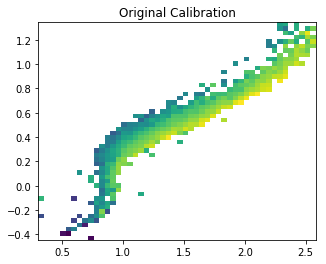

In [7]:
#demonstrate original calibration sample
plt.imshow(ret['original'].T,origin='lower',extent=[xedge['original'].min(),xedge['original'].max(),yedge['original'].min(),yedge['original'].max()])
plt.title('Original Calibration')



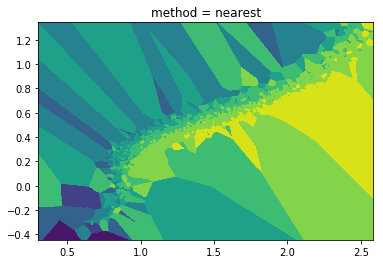

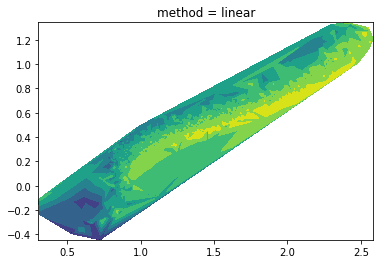

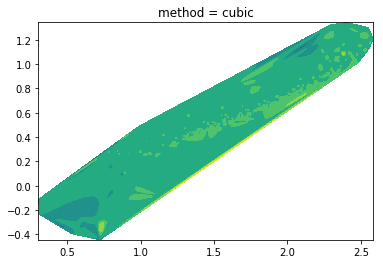

In [8]:
#demonstrate original calibration sample w/ different interpolations
for i, method in enumerate(('nearest','linear','cubic')):
    plt.contourf(x_grid,y_grid,z_grid[method])
    plt.title('method = {}'.format(method))
    plt.show(block=False)

In [9]:
SMASH_fields = [1, 2, 3, 4, 5, 7, 8, 9, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 40, 42, 44, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 66, 68, 149, 150, 156, 176, 177, 178, 246]



In [10]:
#dictionaries to be used in metallicity function
mean_metallicity = {}
std = {}
for i, method in enumerate(('original','nearest','linear','cubic','nearest_regressor','ivezic')):
    mean_metallicity[method] = []
    std[method] = []

In [11]:
def ivezic_equation(x,y):
    return ((-4.37) + (-8.56)*x + (15.5)*y + (-39.0)*x*y + (23.5)*x**2 + (20.5)*y**2 + (12.1)*(x**2)*y + (7.33)*x*(y**2) + (-10.1)*(x**3) + (-21.4)*y**3)


In [12]:
#function to calculate metallicity in SMASH fields of interest
###calculates metallicity using information from binned_statistic_2d 
###reads out metallicity using yumi's method
###output is four different metallicity values: original calibration, nearest interpolation, linear interpolation, cubic interpolation
def metallicity(filename):
    
    #read fits file
    fx = fitsio.FITS(filename)
    objs_new = fx[1].read()
    
    #extract field number from filename string
    newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in filename)
    field_number_transient = [int(i) for i in newstr.split()]
    print("number of initial stars in field "+str(field_number_transient[0])+": "+str(len(objs_new)))
    
    #append to lists
    #field_number.append(field_number_transient[0])
    #initial_star_count.append(len(objs_new))
    
    #deredden the colors from input file
    u = (objs_new["U"]-(4.239*objs_new["EBV"]))
    g = (objs_new["G"]-(3.303*objs_new["EBV"]))
    i = (objs_new["I"]-(1.263*objs_new["EBV"]))
    r = (objs_new["R"]-(2.285*objs_new["EBV"]))

    #make cuts
    selected = np.where(((g-i)>=0.11)&((g-i)<=0.44)&(g>=21.4)&(g<=22.8)&(u<=30)&(r<=30))
    u = u[selected]
    g = g[selected]
    i = i[selected]
    r = r[selected]
    u_g = u-g
    g_r = g-r
    
    #append to list
    #cut_star_count.append(len(cut_u))
    print("number of  stars in field "+str(field_number_transient[0])+" after color/magnitude cuts: "+str(len(u)))
    
    #read out metallicity values from binned_statistic_2d from original calibration sample, and then the different interpolation methods
    for i, method in enumerate(('original','nearest','linear','cubic')):
        ind, = np.where(((u_g)>=xedge[method].min())&((u_g)<=xedge[method].max())&((g_r)>=yedge[method].min())&((g_r)<=yedge[method].max()))
        ix = np.searchsorted(xedge[method],(u_g)[ind])
        ix = ix - 1
        iy = np.searchsorted(yedge[method],(g_r)[ind])
        iy = iy - 1
        feh = ret[method][ix,iy]
        mean_metallicity[method].append(np.nanmean(feh))
        print("mean metallicity for "+method+" method:",(np.nanmean(feh)))
        std[method].append(np.nanstd(feh))
    
    #use machine learning algorithm Nearest Neighbors
    ###The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.
    sample = np.reshape(np.ravel([u_g,g_r],order='F'),(len(u_g),2))   
    knn = neighbors.KNeighborsRegressor(5,weights='uniform')
    feh = knn.fit(points,feh_cal).predict(sample)
    mean_metallicity['nearest_regressor'].append(np.nanmean(feh))
    print("mean metallicity for nearest neighbor regression method:",(np.nanmean(feh)))
    std['nearest_regressor'].append(np.nanstd(feh))
    
    #use equation (4) from Ivezic et al. 2008 to estimate metallicity
    ### x=(u-g) for (g-r)<=0.4; x=(u-g)-2(g-r)+0.8 for (g-r)>0.4
    ### y=(g-r)
    feh = []
    x = u_g -(2*g_r) + 0.8
    index = np.arange(0,len(u_g))
    
    for i in index:
        feh.append([ivezic_equation(u_g[i],g_r[i]) if g_r[i] <= 0.4 else ivezic_equation(x[i],g_r[i])])
        
    mean_metallicity['ivezic'].append(np.nanmean(feh))
    std['ivezic'].append(np.nanstd(feh))
    print('mean metallicity for ivezic equation method: ',(np.nanmean(feh)))
    
    return 0

In [13]:
if __name__=="__main__":
    for number in SMASH_fields:
        metallicity('/Users/amyel/research/SMASH_project/datafiles/SMASH_fields/vsix/starsthree/Field{}_allobj_deep_stars.fits.gz'.format(number))

              

number of initial stars in field 1: 46634
number of  stars in field 1 after color/magnitude cuts: 3759
mean metallicity for original method: -1.2097951863147318
mean metallicity for nearest method: -1.1911266155731983
mean metallicity for linear method: -1.3049085735191597
mean metallicity for cubic method: -1.7120773067430282
mean metallicity for nearest neighbor regression method: -1.7884347
mean metallicity for ivezic equation method:  2.99886976507019
number of initial stars in field 2: 61991
number of  stars in field 2 after color/magnitude cuts: 6029
mean metallicity for original method: -1.3172730586838488
mean metallicity for nearest method: -0.9333481461394066
mean metallicity for linear method: -1.4025642603426216
mean metallicity for cubic method: -1.8323471796682513
mean metallicity for nearest neighbor regression method: -1.5194156
mean metallicity for ivezic equation method:  -1.7204567971697975
number of initial stars in field 3: 847797
number of  stars in field 3 after 

number of initial stars in field 26: 52301
number of  stars in field 26 after color/magnitude cuts: 4426
mean metallicity for original method: -1.3109649187711436
mean metallicity for nearest method: -0.9948371123242122
mean metallicity for linear method: -1.333436853645193
mean metallicity for cubic method: -1.6739195472855428
mean metallicity for nearest neighbor regression method: -1.4680882
mean metallicity for ivezic equation method:  -1.6139608637165492
number of initial stars in field 27: 94878
number of  stars in field 27 after color/magnitude cuts: 21067
mean metallicity for original method: -1.3772395740380585
mean metallicity for nearest method: -0.9956809794342758
mean metallicity for linear method: -1.4438144280635565
mean metallicity for cubic method: -2.120701430249552
mean metallicity for nearest neighbor regression method: -1.6838535
mean metallicity for ivezic equation method:  -2.0428421447921323
number of initial stars in field 28: 114705
number of  stars in field 2

/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal


number of  stars in field 50 after color/magnitude cuts: 878
mean metallicity for original method: -1.3827287133621133
mean metallicity for nearest method: -0.7632036209106445
mean metallicity for linear method: -1.6089498649584109
mean metallicity for cubic method: -2.239813022560567
mean metallicity for nearest neighbor regression method: -2.020391
mean metallicity for ivezic equation method:  4.402227329977016
number of initial stars in field 51: 1574573
number of  stars in field 51 after color/magnitude cuts: 381851
mean metallicity for original method: -1.2569365842724334
mean metallicity for nearest method: -0.8869123051695343
mean metallicity for linear method: -1.2752171640576933
mean metallicity for cubic method: -1.4442433768492242
mean metallicity for nearest neighbor regression method: -1.3332565
mean metallicity for ivezic equation method:  -1.4731451558840059
number of initial stars in field 52: 62890
number of  stars in field 52 after color/magnitude cuts: 2730
mean meta

number of initial stars in field 156: 122018
number of  stars in field 156 after color/magnitude cuts: 1191
mean metallicity for original method: -1.3740961019671998
mean metallicity for nearest method: -1.165666467265079
mean metallicity for linear method: -1.4562129059293105
mean metallicity for cubic method: -1.9821329998221826
mean metallicity for nearest neighbor regression method: -1.6954486
mean metallicity for ivezic equation method:  -0.8852031329846416
number of initial stars in field 176: 111318
number of  stars in field 176 after color/magnitude cuts: 13246
mean metallicity for original method: -1.4142302624616903
mean metallicity for nearest method: -1.038541015924192
mean metallicity for linear method: -1.4874123270786361
mean metallicity for cubic method: -1.7013049862369605
mean metallicity for nearest neighbor regression method: -1.5585363
mean metallicity for ivezic equation method:  -1.735797289712415
number of initial stars in field 177: 98553
number of  stars in fi

/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice
/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
/Users/amyel/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [15]:
#add mean metallicity key/value pair 
###this is the original calibration metallicity with a +.6 dex offset applied
mean_metallicity['offset'] = [i + 0.6 for i in mean_metallicity['original']]
std['offset'] = std['original']

In [16]:
#make table of different mean metallicities of each field and standard deviations
table_array = [(np.array(SMASH_fields))]

for i, method in enumerate(('offset','original','nearest','linear','cubic','nearest_regressor','ivezic')):
    table_array.append(np.array(mean_metallicity[method]).round(decimals=3))
    table_array.append(np.array(std[method]).round(decimals=3))
    
table = Table(table_array,names=('Field Number','Fe/H Original +.6 dex','Offset Std','Std Original','Original Std','Nearest Interp','Nearest Std','Linear Interp','Linear Std','Cubic Interp','Cubic Std','Regressor Method','Regressor Std','Ivezic Method','Ivezic Std'))
ascii.write(table,'MetallicityTable_MethodsSummary.csv',format='csv', fast_writer=False)


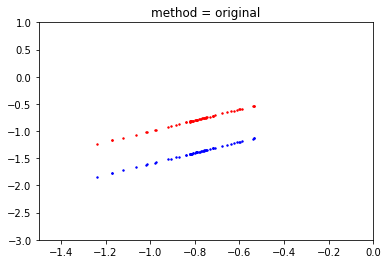

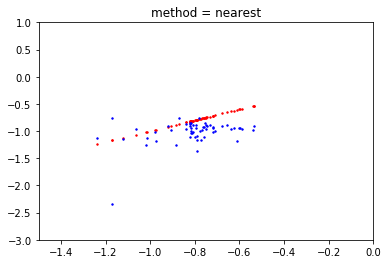

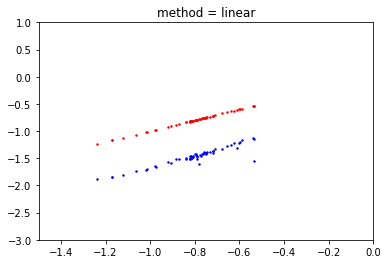

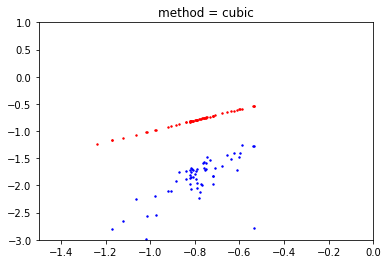

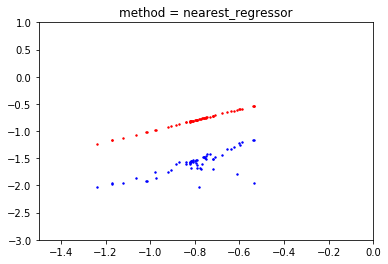

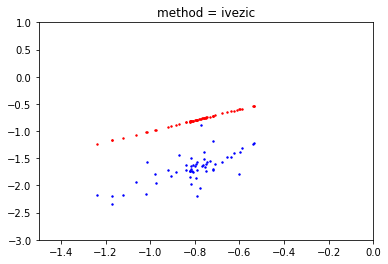

In [17]:
#plot original Fe/H w/ +.6 offset versus all the different methods
for i, method in enumerate(('original','nearest','linear','cubic','nearest_regressor','ivezic')):
    plt.scatter(mean_metallicity['offset'],mean_metallicity['offset'],s=2,c='r')
    plt.scatter(mean_metallicity['offset'],mean_metallicity[method],s=2,c='b')
    plt.title('method = {}'.format(method))
    plt.xlim(-1.5,0)
    plt.ylim(-3,1) 
    plt.show(block=False)
    

    

### Investigate color-color plots of calibration sample, entire SMASH stands stars, and sample of SMASH fields

(-1, 2)

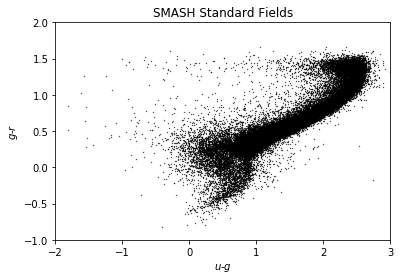

In [18]:
#color-color plot of all stars in SMASH standard star fields
standards = '/Users/amyel/research/SMASH_project/datafiles/smash_standards.fits'
fx = fitsio.FITS(standards)
objs = fx[1].read()
u_std = (objs["U"]-(4.239*objs["EBV"]))
g_std = (objs["G"]-(3.303*objs["EBV"]))
i_std = (objs["I"]-(1.263*objs["EBV"]))
r_std = (objs["R"]-(2.285*objs["EBV"]))
selected = np.where((u_std<=30)&(r_std<=30)&(g_std<=30))
u_std,g_std,r_std = u_std[selected],g_std[selected],r_std[selected]
plt.scatter((u_std-g_std),(g_std-r_std),s=0.1,c='k')
plt.title('SMASH Standard Fields')
plt.xlabel('$u$-$g$')
plt.ylabel('$g$-$r$')
plt.xlim(-2,3)
plt.ylim(-1,2)

In [29]:
def color_color_plot(filename):

    fx = fitsio.FITS(filename)
    objs = fx[1].read()
    
    newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in filename)
    field_number_transient = [int(i) for i in newstr.split()]
    
    u = (objs["U"]-(4.239*objs["EBV"]))
    g = (objs["G"]-(3.303*objs["EBV"]))
    i = (objs["I"]-(1.263*objs["EBV"]))
    r = (objs["R"]-(2.285*objs["EBV"]))
    selected = np.where((u<=30)&(r<=30)&(g<=30))
    u,g,r = u[selected],g[selected],r[selected]
    
    black = mlines.Line2D([], [], color='k', marker='.',linestyle='None',markersize=10, label='SMASH Standards')
    red = mlines.Line2D([], [], color='r', marker='.',linestyle='None',markersize=10, label='Field '+str(field_number_transient[0]))
    
    fig, (ax1,ax2) = plt.subplots(1,2)

    ax1.scatter((u-g),(g-r),s=0.1,c='r')
    ax1.set_xlim(-2,3)
    ax1.set_ylim(-1,2)
    ax1.set_xlabel('$u$-$g$')
    ax1.set_ylabel('$g$-$r$')

    ax2.scatter((u-g),(g-r),s=0.1,c='r')
    ax2.scatter((u_std-g_std),(g_std-r_std),s=0.1,c='k')
    ax2.set_xlim(-2,3)
    ax2.set_ylim(-1,2)
    ax2.set_xlabel('$u$-$g$')
    ax2.set_ylabel('$g$-$r$')
    
    ax1.legend(handles=[red])
    ax2.legend(handles=[black,red])
    
    plt.tight_layout()
    plt.show(block=False)
    
    return 0 

In [30]:
#choose a good selection of SMASH fields on LMC periphery, mainbody and SMC periphery, mainbody
fields = [3,5,12,13,40,48,50,56,58,59,176,178]


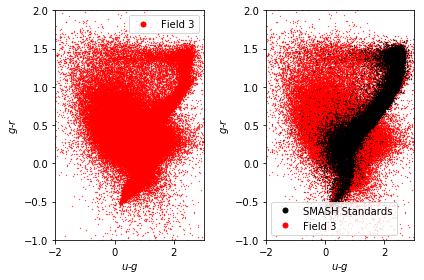

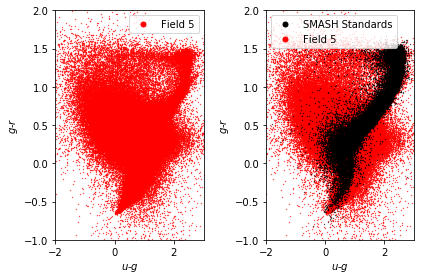

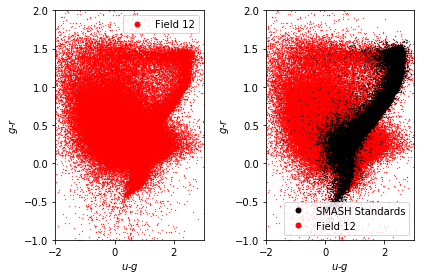

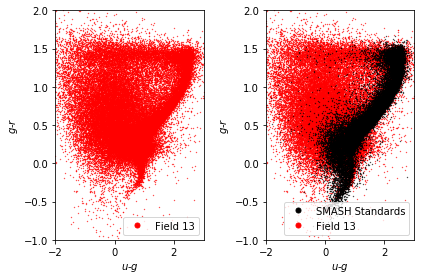

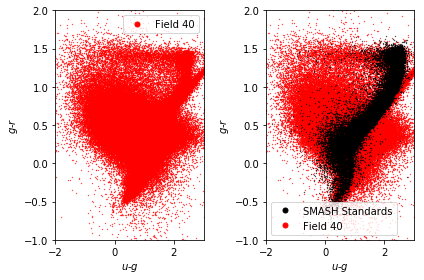

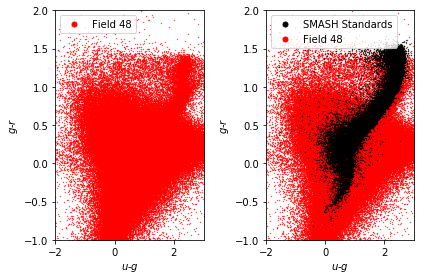

/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal
  del sys.path[0]


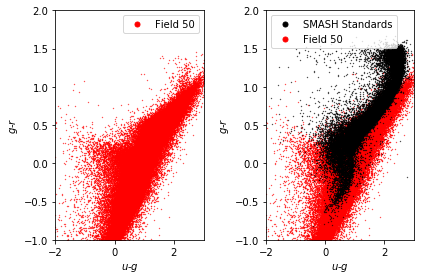

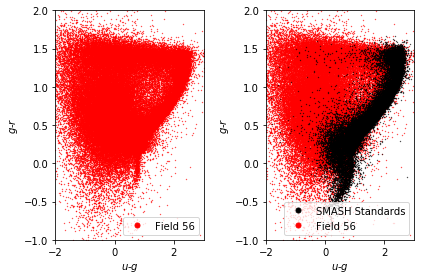

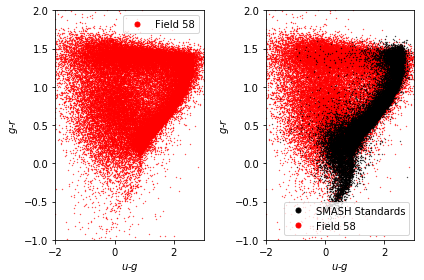

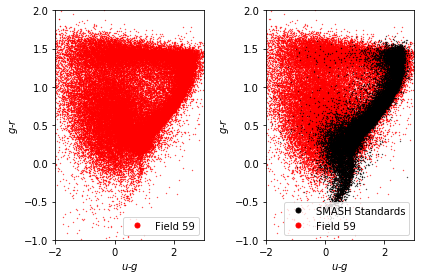

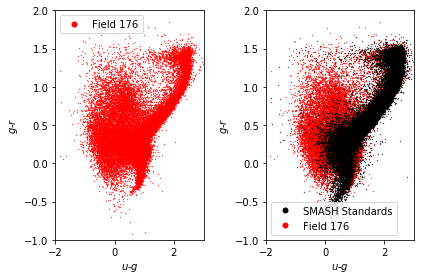

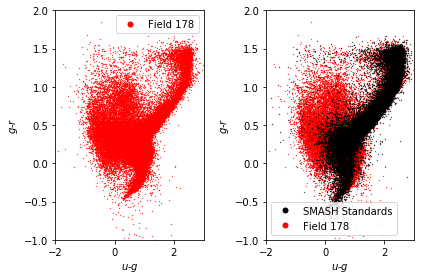

In [31]:
if __name__=="__main__":
    for number in fields:
        color_color_plot('/Users/amyel/research/SMASH_project/datafiles/SMASH_fields/vsix/starsthree/Field{}_allobj_deep_stars.fits.gz'.format(number))

              